# ACM Imbalanced Learning - Sampling Methods

This notebook contains a selection of various sampling methods used to modify an imbalanced dataset. These include undersampling and oversampling techniques. To simplify the visualization of the sampling, and keep runtime down, a small generated dataset it used.

In [2]:
# Import useful libraries used in the notebook
import time
import numpy as np
import matplotlib.pyplot as plt

# Show plots inline 
%matplotlib inline

from sklearn.datasets import make_classification

from pylab import rcParams

# Functions are defined in this module
from acm_imbalanced_library import *

# Auto-reload external modules
%load_ext autoreload
%autoreload 2

plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=.95)
rcParams['figure.figsize'] = (10.0, 5.0)

def comp_scatter(x_left, y_left, title_left, x_right=None, y_right=None, title_right=None):
    '''
    Utility function to create comparison scatter plots. 
    '''
    # Plot left-hand scatterplot
    plt1 = plt.subplot(121)
    plt.title(title_left, fontsize='large')
    y_left = np.squeeze(y_left)
    plt1.scatter(x_left[y_left == 0][:, 0], x_left[y_left == 0][:, 1], s=100, marker = "x", color="black")
    plt1.scatter(x_left[y_left == 1][:, 0], x_left[y_left == 1][:, 1], s=100, marker = "s", color="red")
    if (title_right == None):
        return 
    
    # Plot right hand scatterplot
    plt.subplot(122, sharex=plt1, sharey=plt1)
    plt.title(title_right, fontsize='large')
    y_right = np.squeeze(y_right)
    plt.scatter(x_right[y_right == 0][:, 0], x_right[y_right == 0][:, 1], s=100, marker = "x", color="black")
    plt.scatter(x_right[y_right == 1][:, 0], x_right[y_right == 1][:, 1], s=100, marker = "s", color="red")


    
    return 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate the dataset for use in the sampling code below.

To demonstrate the sampling methods, we'll generate a small dataset using scikit-learn's ```make_classification``` function we imported earlier. This has many parameters to control the generated data, the main ones we're using here are:

* Generate 100 samples - ```n_samples = 100```
* Use imbalance of 90:10 - ```weights=[0.9, 0.1]```
* Give repeatable data - ```random_state=23```


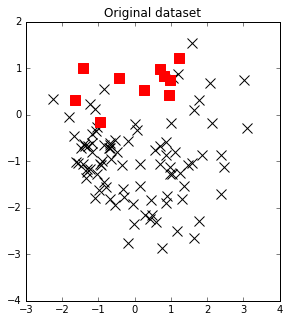

In [3]:
plt1 = plt.subplot(121)
plt.title("Original dataset", fontsize='large')
X, y = make_classification(n_samples=100, n_features=2, 
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2, weights=[0.9, 0.1],
                           random_state=23)
comp_scatter(X, y, 'Original dataset')


# Random Oversampling

In Random Oversampling, minority classes are duplicated and added to the dataset at random (with replacement). This can lead to overfitting due to the many duplicated minority cases which don't add any new information to the model. 

It's hard to make out the effect on the scatterplot, as replacement minority examples are duplicated exactly.

Y value counts (original data) = (array([0, 1]), array([90, 10]))
Y value counts (oversampled data) = (array([0, 1]), array([90, 90]))


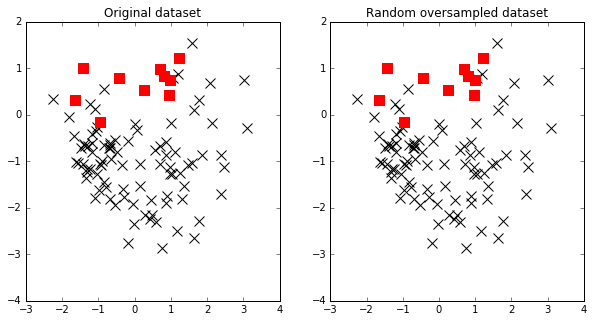

In [9]:
# Randomly oversample the data
X_oversamp, y_oversamp = randomOversample(X, y)

comp_scatter(X, y, 'Original dataset', 
             X_oversamp, y_oversamp, 'Random oversampled dataset')


print 'Y value counts (original data) = {}'.format(np.unique(y, return_counts = True))
print 'Y value counts (oversampled data) = {}'.format(np.unique(y_oversamp, return_counts=True))



# Random Undersampling

Random undersampling is the opposite of random oversampling. Instead of adding more minority examples, majority examples are removed to correct the balance.


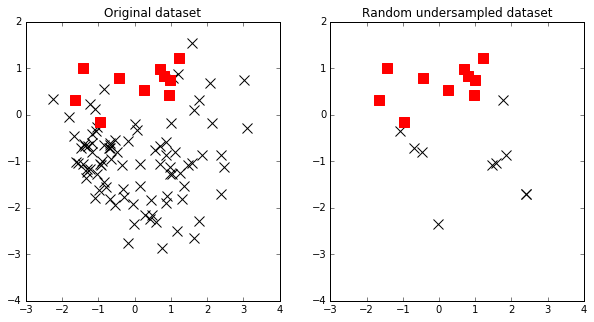

In [11]:
# Randomly undersample the data
X_undersamp, y_undersamp = randomUndersample(X, y)

comp_scatter(X, y, 'Original dataset', 
             X_undersamp, y_undersamp, 'Random undersampled dataset')

# SMOTE: Synthetic Minority Over-sampling Technique

For a full description of the algorithm, see [1]. Simplified pseudocode is shown below:

```
For each minority example 'm':
    Find k-nearest neighbours, store in array
    
For each minority example 'm':
    'a' := One of k nearest neighbours to m
    'c' := random uniform float between 0.0 and 1.0
    'b' := Interpolate between 'm' and 'a' using 'c'
```
[1] Chawla et al, "SMOTE: Synthetic Minority Over-sampling Technique", Journal of Artificial Intelligence Research 16 (2002).

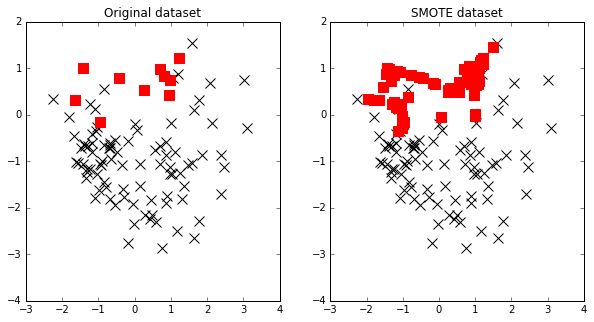

In [14]:
X_smote, y_smote = SMOTEoversample(X, y)

comp_scatter(X, y, 'Original dataset', 
             X_smote, y_smote, 'SMOTE dataset')


# Tomek Links

Here we'll check for Tomek links (see [2]), and where found remove the majority example.

Simplified pseudocode is shown below.

```
For each example 'a':
    For each example 'b'
        Calculate distance between examples
    
For each minority example 'm':
    Find closest majority example 'n'.
    Is minority example 'm' the closest example to majority ex. 'n'?
        Remove majority example.
    
```

[2] - Two Modifications of CNN, IEEETRANSACTIONS ON SYSTEMS,MAN, AND CYBERNETICS, NOVEMBER 1976.

In [7]:
# Split data into minority and majority example arrays
X_min = X[y == 1]
X_maj = X[y == 0]
num_all = X.shape[0]
num_min = X_min.shape[0]
num_maj = X_maj.shape[0]

# Generate matrix of 2-norms between minority and majority .
# Rows are minority indexes, columns are majority
knn_dist = np.zeros((num_all, num_all))
for a_idx, a_val in enumerate(X):
    for b_idx, b_val in enumerate(X):
        knn_dist[a_idx, b_idx] = np.sqrt(np.sum(np.square(a_val - b_val)))
        


        

# Iterate through majority examples:
# -> Find the closest minority example.
# -> Is the majority example the closest to the minority example too?
#    -> Remove the majority example.

for i in xrange(10):
    x_maj_idx_remove = []

    for x_maj_idx, x_maj_val in enumerate(x_maj):
        nearest_x_min_idx = knn_min_sorted_idx[i, x_maj_idx]
    #     print 'x_maj = {}, nearest x_min = {}'.format(x_maj_idx, nearest_x_min_idx)

        if (knn_maj_sorted_idx[nearest_x_min_idx,i] == x_maj_idx):
    #         print 'Nearest x_maj = {}'.format(x_maj_idx)
            x_maj_idx_remove.append(x_maj_idx)

    if (len(x_maj_idx_remove) > 0):
        print 'Removing major instances indexes {}'.format(x_maj_idx_remove)
        x_maj = np.delete(x_maj, x_maj_idx_remove, 0)
        
# Re-assemble the data for plotting.
x_tomek_out = np.vstack((x_min, x_maj))
y_tomek_out = np.hstack((np.ones(x_min.shape[0]), np.zeros(x_maj.shape[0])))

comp_scatter(x, y, 'Original dataset', 
             x_tomek_out, y_tomek_out, 'Tomek link dataset')



NameError: name 'x' is not defined

(80, 2)
